In [1]:
import csv
import numpy as np
import pandas as pd

import cv2
from matplotlib import pyplot as plt

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [52]:
# remove prefixes
import os
path = '/media/stanislau/82db778e-0496-450c-9b25-d1e50a90e476/data/data4stas/01_data_cls/'
os.chdir(path)

In [ ]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [5]:
import scipy.ndimage as ndi

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.

    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=0,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

class BrodatzImageDataGenerator(ImageDataGenerator):
    def random_transform(self, x, seed=None):
        """Randomly augment a single image tensor.

        # Arguments
            x: 3D tensor, single image.
            seed: random seed.

        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        if seed is not None:
            np.random.seed(seed)

        # use composition of homographies
        # to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0

        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_axis]
        else:
            ty = 0

        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            if np.random.random() < 0.5:
                zx = zy = self.zoom_range[0] + np.random.uniform(-0.05, 0.05)
            else:
                zx = zy = self.zoom_range[1] + np.random.uniform(-0.05, 0.05)

        transform_matrix = None
        if theta != 0:
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                        [np.sin(theta), np.cos(theta), 0],
                                        [0, 0, 1]])
            transform_matrix = rotation_matrix

        if tx != 0 or ty != 0:
            shift_matrix = np.array([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1]])
            transform_matrix = shift_matrix if transform_matrix is None else np.dot(transform_matrix, shift_matrix)

        if shear != 0:
            shear_matrix = np.array([[1, -np.sin(shear), 0],
                                    [0, np.cos(shear), 0],
                                    [0, 0, 1]])
            transform_matrix = shear_matrix if transform_matrix is None else np.dot(transform_matrix, shear_matrix)

        if zx != 1 or zy != 1:
            zoom_matrix = np.array([[zx, 0, 0],
                                    [0, zy, 0],
                                    [0, 0, 1]])
            transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)

        if transform_matrix is not None:
            h, w = x.shape[img_row_axis], x.shape[img_col_axis]
            transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
            x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x,
                                     self.channel_shift_range,
                                     img_channel_axis)
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_axis)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_axis)

        return x

In [111]:
def process_file(path):
    df = pd.read_csv(path)
    
    x = []
    y = []
    filenames = []

    for index, row in df.iterrows():
        x.append(cv2.imread(row[0], cv2.IMREAD_GRAYSCALE))
        y.append(float(row[1]))

    x = np.array(x)
    y = np.array(y)
    
    num_classes = len(np.unique(y))

    x = x.reshape(x.shape + (-1,))
    x = x.astype('float32') / 255
    
    y = y - 1
    y = keras.utils.to_categorical(y, num_classes=num_classes)

    return x, y, num_classes

def probas_to_classes(y_prob):
    return np.argmax(y_prob, axis=1) + 1

def accuracy(y_test, y_predict):
    return np.sum(np.argmax(y_predict, axis=1) == np.argmax(y_test, axis=1))/y_predict.shape[0]

def process_file_some_classes(path, classes):
    df = pd.read_csv(path)
    
    x = []
    y = []

    for index, row in df.iterrows():
        x.append(cv2.imread(row['FilePath'], cv2.IMREAD_GRAYSCALE))
        y.append(float(row['ClassId']))

    x = np.array(x)
    y = np.array(y) - 1
        
    num_classes = len(classes)

    x = x.reshape(x.shape + (-1,))
    x = x.astype('float32') / 255
    
    x = x[np.in1d(y, classes)]
    y = y[np.in1d(y, classes)]
    
    y = keras.utils.to_categorical(y, num_classes=num_classes)

    return x, y, num_classes
            

def process_line(line):
    pass

def generate_arrays_from_file(path):
    df = pd.read_csv(path)
    
    while 1:
        f = open(path)
        for line in f:
            # create numpy arrays of input data
            # and labels, from each line in the file
            x1, x2, y = process_line(line)
            yield ({'input_1': x1, 'input_2': x2}, {'output': y})
        f.close()
        
def plot(x):
    plt.imshow(x.reshape(x.shape[:-1]), cmap=plt.cm.gray)
    plt.show()
    
def model_1(num_classes):
    model = Sequential()
    # input: 200x200 grayscale images -> (200, 200, 1) tensors.
    # this applies 8 convolution filters of size 3x3 each.
    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(200, 200, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     model.add(Conv2D(512, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01), activation='softmax'), )

#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def fit_1(model, x, y, classes, batch_size=32, epochs=100):
    x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test.csv', classes)
    return model.fit(x, y, batch_size=50, epochs=epochs, validation_data=(x_test, y_test))

def fit_generator_1(model, x, y, classes, batch_size=32, epochs=100):
    datagen = ImageDataGenerator(
        rotation_range=40,
        shear_range=0.4,
        width_shift_range=0.6,
        height_shift_range=0.6,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=2,
        fill_mode='reflect')
    
    x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test2.csv', classes)
    return model.fit_generator(datagen.flow(x, y, batch_size=batch_size), validation_data=(x_test, y_test),
                    steps_per_epoch=len(x) / batch_size, epochs=epochs)

def test_1(model, classes, batch_size=32):
    test_paths = ['Alexander_cls_train.csv',
                 'Alexander_cls_test.csv',
                 'Alexander_cls_test1.csv',
                 'Alexander_cls_test2.csv',
                 'Alexander_cls_test3.csv',
                 'Alexander_cls_test4.csv']

    for test_path in test_paths:
        x_test, y_test, num_classes = process_file_some_classes(test_path, classes)
        score = model.evaluate(x_test, y_test, batch_size=batch_size)
        print(test_path + ' : ' + ', '.join(str(x) for x in score))
        
def pipe_1():
    classes = np.arange(0, 15)
    x, y, num_classes = process_file_some_classes('Alexander_cls_train.csv', classes)
    
    model = model_1(num_classes)
    
    batch_size = 50
    epochs = 30
    history = fit_1(model, x, y, classes, batch_size, epochs)
    test_1(model, classes, batch_size)
    return history

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history.get('val_acc')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss)
    if val_loss is not None:
        plt.plot(epochs, val_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(epochs, acc)
    if val_acc is not None:
        plt.plot(epochs, val_acc)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def predict_1(model, classes):
    x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test.csv', classes)
    y_predict = model.predict(x_test, batch_size=32)
    
def save_model(model):
    path = '/media/stanislau/82db778e-0496-450c-9b25-d1e50a90e476/data/data4stas/brodaz'
    current_dir = os.getcwd()
    os.chdir(path)

    input_filename = 'brodatz_dataset_test_submit.csv'
    output_filename = 'brodatz_dataset_test_submit_0'    
    
    x_test, y_test, num_classes = process_file(input_filename)
    df = pd.read_csv(input_filename)
    y_pred = model.predict_classes(x_test) + 1
    df[df.columns[1]] = y_pred
    df.to_csv(output_filename, index=False)
    
    os.chdir(current_dir)

In [58]:
save_model(model)

2208/2220 [============================>.] - ETA: 0s

In [ ]:
x, y, num_classes = process_file('Alexander_cls_train.csv')

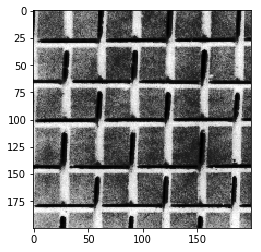

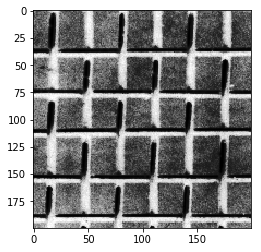

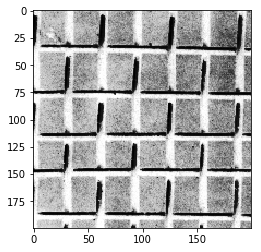

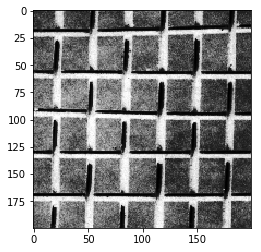

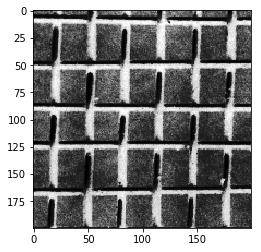

[None, None, None, None, None]

In [376]:
[plot(img) for img in x[probas_to_classes(y) == 1]]

In [105]:
classes = np.arange(0, 5)
x, y, num_classes = process_file_some_classes('Alexander_cls_train.csv', classes)

In [ ]:
model = model_1(num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 198, 198, 64)      640       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 97, 97, 128)       73856     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 46, 46, 256)       295168    
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 23, 23, 256)       0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 135424)            0         
__________

In [ ]:
batch_size = 128
epochs = 600
history = fit_generator_1(model, x, y, classes, batch_size, epochs=epochs)
test_1(model, classes, batch_size)

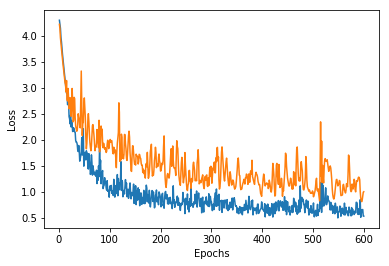

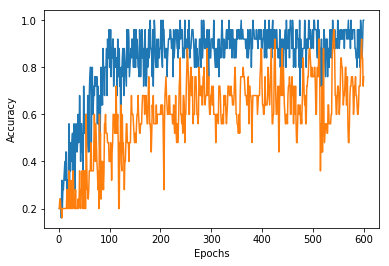

In [110]:
plot_history(history)

In [108]:
x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test2.csv', classes)
y_predict_classes = model.predict_classes(x_test, batch_size=32) + 1

25/25 [==============================] - 0s


In [109]:
y_test_classes = probas_to_classes(y_test)
print(y_test_classes)

print(y_predict_classes)

[2 5 4 3 1 2 5 4 3 1 2 5 4 3 1 2 5 4 3 1 2 5 4 3 1]
[4 5 4 3 1 4 5 4 3 1 4 5 4 3 1 4 5 4 2 1 4 5 4 3 1]


In [98]:
y.shape

(25, 5)

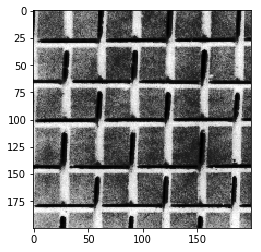

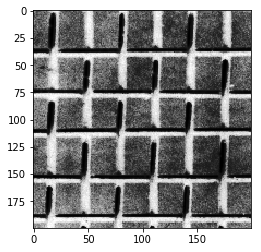

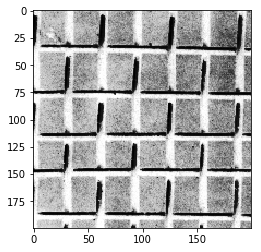

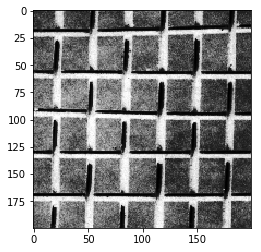

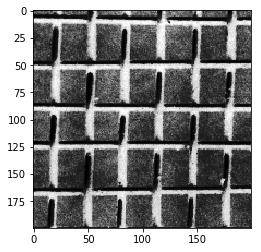

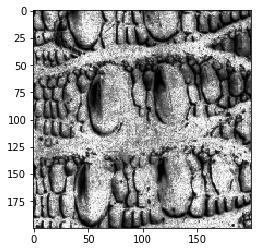

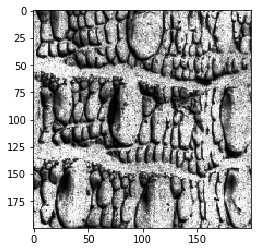

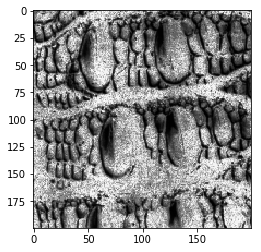

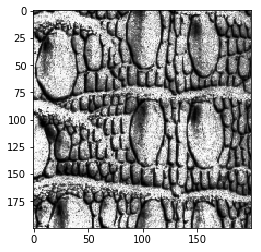

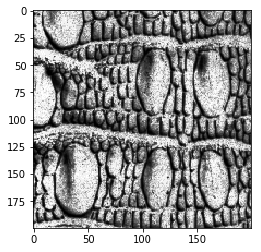

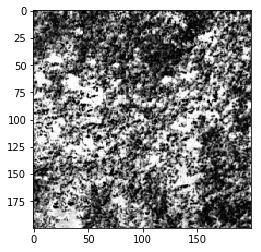

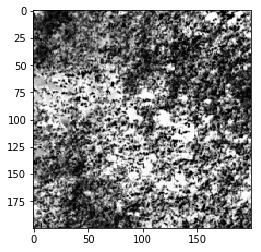

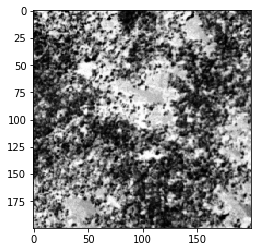

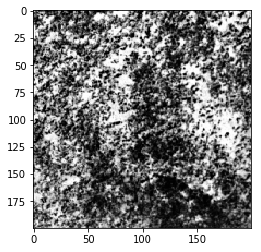

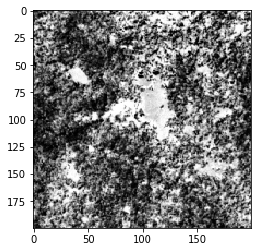

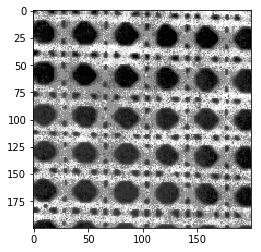

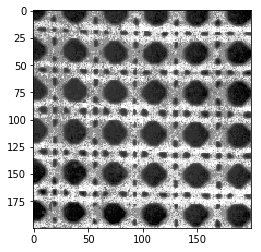

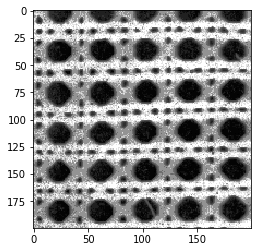

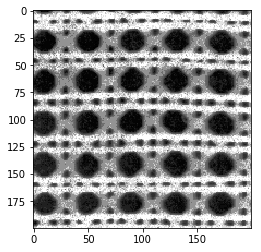

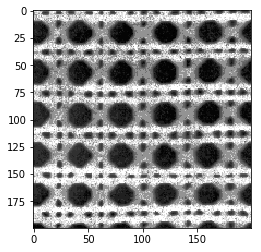

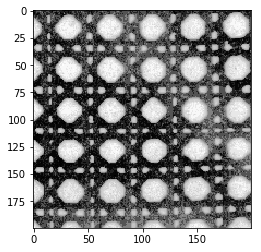

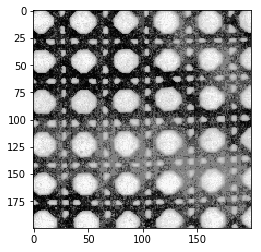

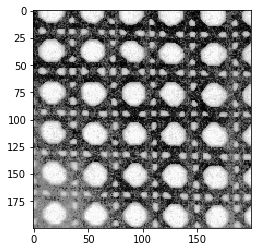

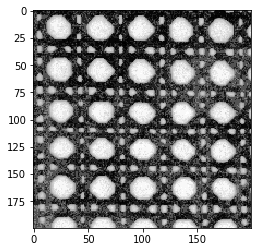

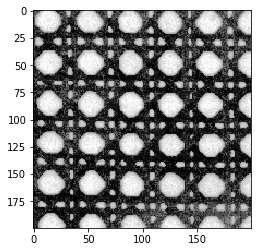

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [102]:
[plot(img) for img in x]

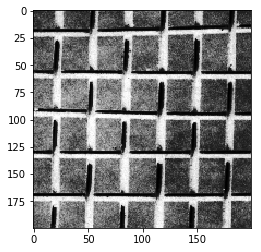

[None]

In [101]:
[plot(img) for img in x[y_predict_classes == 2]]

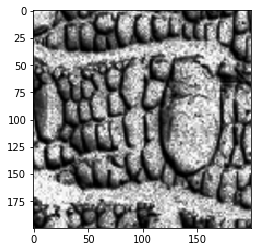

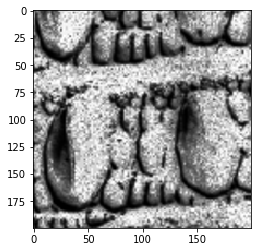

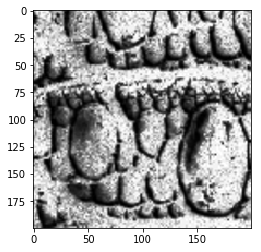

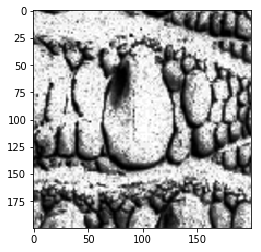

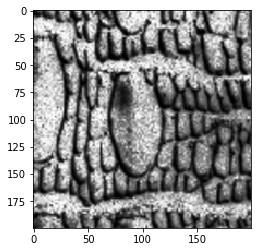

[None, None, None, None, None]

In [103]:
[plot(img) for img in x_test[y_test_classes == 2]]

In [227]:
np.unique(np.argmax(y_predict, axis=1))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
model = Sequential()
# input: 200x200 grayscale images -> (200, 200, 1) tensors.
# this applies 8 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(200, 200, 1)))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (2, 2), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (2, 2), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, (2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01), activation='softmax'), )
model.add(Dropout(0.5))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# model.fit(x, y, batch_size=8, epochs=10, validation_data=(x_train, y_train))
model.fit(x, y, batch_size=32, epochs=500)

In [ ]:
x_test, y_test, num_classes = process_file('Alexander_cls_train.csv')

In [ ]:
batch_size = 20
model.fit_generator(datagen.flow(x, y, batch_size=batch_size),
                    steps_per_epoch=len(x) / batch_size * 10, epochs=500, use_multiprocessing=True, workers=20)

In [ ]:
test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

test_datagen.fit(x)

test_paths = ['Alexander_cls_train.csv',
             'Alexander_cls_test.csv',
             'Alexander_cls_test1.csv',
             'Alexander_cls_test2.csv',
             'Alexander_cls_test3.csv',
             'Alexander_cls_test4.csv']

batch_size = 32

for test_path in test_paths:
    x_test, y_test, num_classes = process_file(test_path)
    score = model.evaluate_generator(test_datagen.flow(x_test, y_test, batch_size=batch_size), steps=len(x_test) / batch_size)
    print(test_path + ' : ' + ', '.join(str(x) for x in score))

In [ ]:
model.evaluate(x, y, batch_size=32)

In [ ]:
y_predict = model.predict(x_test, batch_size=32)

In [ ]:
y_predict.shape

In [ ]:
np.argmax(y_test, axis=1).shape

In [ ]:
np.sum(np.argmax(y_predict, axis=1) == np.argmax(y_test, axis=1))/y_predict.shape[0]

In [ ]:
np.unique(np.argmax(y_predict, axis=1))

In [ ]:
model.summary()

In [ ]:
# спросить про 500 samples на класс (хорошо, но можно оверфитнуться)
# когда 50 сэмплов хорошо, обычно плохо